# Idealized Profiles Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import gsw
from cmocean import cm
from importlib import reload
import scipy.ndimage as filter

GIVE INTRO TO THIS NOTEBOOK HERE

In this notebook, I'm using functions I've already written for tasks such as filtering, calculating the mixed layer depth, and accessing variance metrics. For increased "readability" I've copied and pasted them directly into this noteobok so it's easy to check the code itself if there are any questions or uncertainties.

### Creating Profiles

In [2]:
depth_grid = np.linspace(0,2000,1000)
temp_exp = np.exp(-depth_grid/150)*10
psal_exp = (-np.exp(-depth_grid/550)*2)+35

In [3]:
temp_noise = (1/5)*np.sin((1/25)*(depth_grid))
psal_noise = (1/25)*np.sin((1/40)*(depth_grid))

In [4]:
temp_prof = temp_exp + temp_noise[::-1]
psal_prof = psal_exp + psal_noise[::-1]

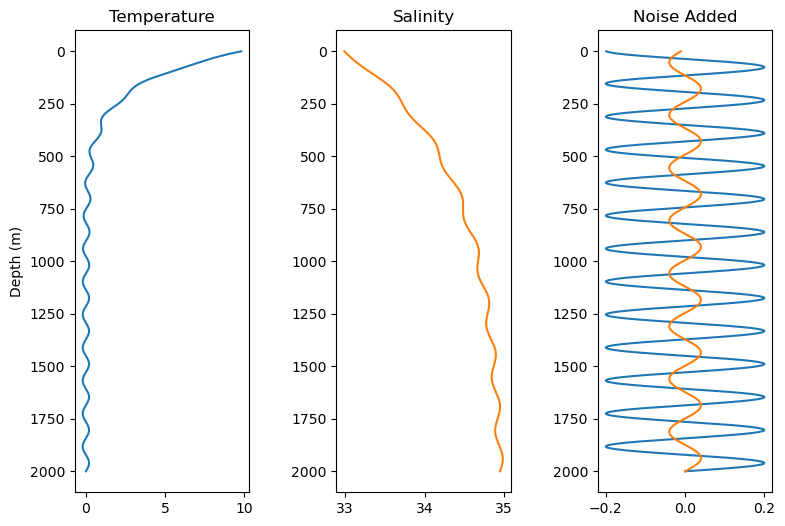

In [5]:
plt.figure(figsize=(9,6))
plt.subplot(131)
plt.plot(temp_prof,  depth_grid,color='tab:blue')
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.title('Temperature')

plt.subplot(132)
plt.plot(psal_prof  ,depth_grid,color='tab:orange')
plt.gca().invert_yaxis()
plt.title('Salinity')

plt.subplot(133)
plt.plot(temp_noise[::-1],depth_grid)
plt.plot(psal_noise[::-1],depth_grid)
plt.gca().invert_yaxis()
plt.title('Noise Added')

plt.subplots_adjust(wspace=0.5)

The above plot shows idealized profiles of temperature and salinity, where the overall signal is the sum of a large-scale exponential gradient and small-scale variation from a sine wave. I tried to keep the values somewhat realistic because I will next calculate density and spice for the profile using the gsw package.

NOTE:

**Want to create profiles where gradient becomes small at some intermediate depth, look at T/S profiles where intermediate waters are. Remember what we're looking for is do EKE have to**

In [6]:
dens_prof = gsw.density.rho(psal_prof,temp_prof,depth_grid)
spic_prof = gsw.spiciness0(psal_prof,temp_prof)

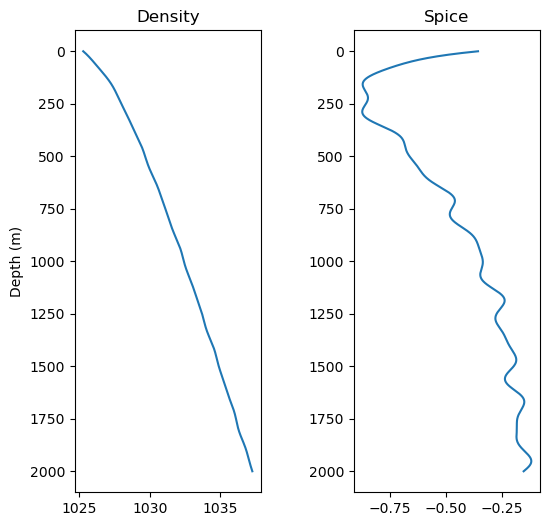

In [7]:
plt.figure(figsize=(6,6))

plt.subplot(121)
plt.plot(dens_prof,depth_grid)
plt.gca().invert_yaxis()
plt.ylabel('Depth (m)')
plt.title('Density')

plt.subplot(122)
plt.plot(spic_prof,depth_grid)
plt.gca().invert_yaxis()
plt.title('Spice')

plt.subplots_adjust(wspace=0.5)

In [8]:
temp_stack = np.vstack((temp_prof,temp_prof))
psal_stack = np.vstack((psal_prof,psal_prof))
dens_stack = np.vstack((dens_prof,dens_prof))
spic_stack = np.vstack((spic_prof,spic_prof))

In [9]:
#create a float-style dataset with coordinates temperature, salinity, and spice;
#and dimensions profile and depth

ds = xr.Dataset(coords=dict(profile=(['profile'],np.array([0,1])),
                           depth=(['depth'],depth_grid)),
           data_vars=dict(temperature=(['profile','depth'],temp_stack),
                          salinity=(['profile','depth'],psal_stack),
                          density=(['profile','depth'],dens_stack),
                          spice=(['profile','depth'],spic_stack)))

In [10]:
# add mixed layer depth as a coordinate in ds
#this function is from MLD_funcs.py
def get_MLD(ds,threshold=0.03,variable='SIG0',dim1='N_PROF',dim2='PRES_INTERPOLATED'):
    '''Takes an xarray and returns a new coordinate "MLD" or mixed layer depth for each profile, defined using the density threshold from the surface.
    ds: xarray with profile and pressure dimensions
    threshold: density value that defines the boundary of the mixed layer, default=0.03
    variable: density coordinate, default='SIG0'
    dim1: profile dimension, default='N_PROF'
    dim2: pressure dimension, default='PRES_INTERPOLATED'
    '''
    
    MLD_li = []
    
    for n in range(0, len(ds[dim1])):
        SIG0_surface = ds.isel({dim1:n})[variable].isel({dim2:0})
        SIG0_diff    = SIG0_surface + threshold
        MLD_ds       = SIG0_surface.where(ds.isel({dim1:n})[variable] < SIG0_diff)
        MLD          = MLD_ds.dropna(dim2).isel({dim2:-1})[dim2].values
        MLD_li.append(MLD)
        
    return ds.assign_coords(MLD=(dim1,MLD_li))

ds = get_MLD(ds,dim1='profile',dim2='depth',variable='density')
ds

<xarray.Dataset>
Dimensions:      (profile: 2, depth: 1000)
Coordinates:
  * profile      (profile) int64 0 1
  * depth        (depth) float64 0.0 2.002 4.004 ... 1.996e+03 1.998e+03 2e+03
    MLD          (profile) float64 0.0 0.0
Data variables:
    temperature  (profile, depth) float64 9.801 9.671 9.544 ... 0.01602 1.62e-05
    salinity     (profile, depth) float64 32.99 32.99 33.0 ... 34.95 34.95 34.95
    density      (profile, depth) float64 1.025e+03 1.025e+03 ... 1.037e+03
    spice        (profile, depth) float64 -0.3556 -0.3743 ... -0.1491 -0.1514

In [11]:
temp_grad = np.gradient(ds.temperature.isel(profile=0))
psal_grad = np.gradient(ds.salinity.isel(profile=0))
spic_grad = np.gradient(ds.spice.isel(profile=0))

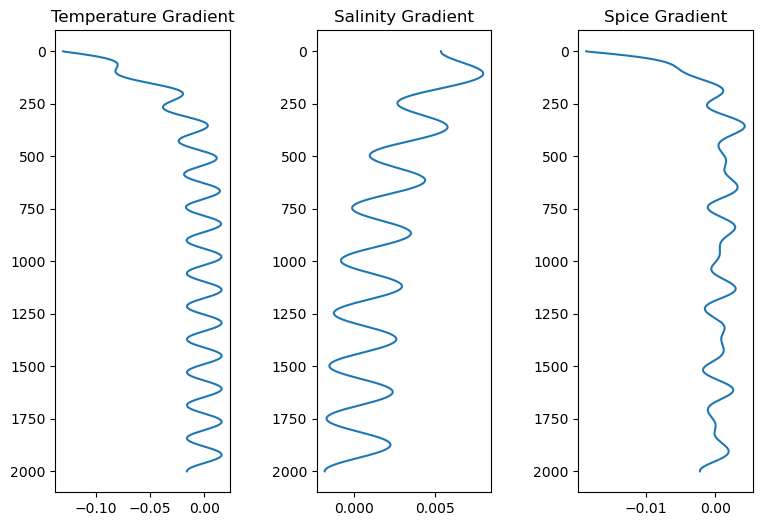

In [12]:
plt.figure(figsize=(9,6))

plt.subplot(131)
plt.plot(temp_grad,depth_grid)
plt.gca().invert_yaxis()
plt.title('Temperature Gradient')

plt.subplot(132)
plt.plot(psal_grad,depth_grid)
plt.gca().invert_yaxis()
plt.title('Salinity Gradient')

plt.subplot(133)
plt.plot(spic_grad,depth_grid)
plt.gca().invert_yaxis()
plt.title('Spice Gradient')

plt.subplots_adjust(wspace=0.5)

This doesn't feel very relevant right now. Maybe remove the gradient piece, or at least move it to somewhere else in the notebook.

### Filtering Methods

In [13]:
#assign filter scale
lfilter = 100
variable='temperature'

In [14]:
#convert scale from meters to gridpoints
#this function is from filt_funcs.py
def get_nfilter(ds, lfilter, dim2='PRES_INTERPOLATED'):
    
    '''Takes an xarray (to determine dx) and a filter scale in meters. Returns the corresponding filter scale in gridpoints.
    
    ds: xarray dataset with pressure dimension
    lfilter: filter scale in meters
    dim2: pressure dimension, filtering occurs along this dimension, default=PRES_INTERPOLATED'''
    
    dx = (ds[dim2].isel({dim2:1})-ds[dim2].isel({dim2:0})).values
    sigmafilter = lfilter/np.sqrt(12)
    nfilter = sigmafilter/dx
    
    return nfilter

I know we already went through this, but I don't exactly remember where this factor of $\sqrt{12}$ comes from. Worth putting notes here describing each step of this correction from meters to gridpoints

In [15]:
#create a mask with zeros on the upper bound of MLD+lfilter, and a lower bound of lfilter (and ones between)
#this function is from filt_funcs.py
def get_mask(ds, scale, variable_MLD='MLD', dim1='profile', dim2='depth', bound=True):
    
    '''Takes an xarray and returns a dim1 length list of 1d np arrays with length of dim2 that contains:
    1) bound=False: ones
    2) bound=True: zeroes one filter scale away from the top (ML base) and bottom (profile bottom) boundaries, and ones between.
    
    ds: xarray dataset with pressure dimension
    scale: int/float, used to determine the amount of pressures that will go to zero
    variable: coordinate of mixed layer depth, default=MLD
    dim1: profile dimension, default=N_PROF
    dim2: pressure dimension, filtering occurs along this dimension, defualt=PRES_INTERPOLATED
    bound: will boundary regions become zeros?, default=False'''

    mask_li = []
    
    if bound==False:
        for n in range(0,len(ds[dim1])):
            mask = np.ones((len(ds[dim2])))
            mask_li.append(mask)
        
    if bound==True:
        for n in range(0,len(ds[dim1])):
            start = ds[variable_MLD][n].values + scale
            end = ds[dim2].isel({dim2:-1}).values - scale
            mask = ds[dim2].where(ds[dim2]>start).where(ds[dim2]<end).values
            
            mask[np.greater(mask,0)] = 1
            mask[np.isnan(mask)] = 0
            mask_li.append(mask)
    
    return mask_li

In [16]:
#filter profiles
#this function is from filt_funcs.py
def get_filt_single(ds, lfilter, variable, dim1='profile', dim2='depth', bound=True):
    
    '''Takes an xarray and a filter scale in meters and returns an xarray with additional coordinates N_PRPF_NEW for a sequence that can be plotted and MASK for the boundary correction.
    
    ds: xarray dataset with pressure dimension
    lfilter: filter scale in meters
    variable: coordinate to filter, default=CT
    dim1: profile dimension, default=N_PROF
    dim2: pressure dimension, filtering occurs along this dimension, default=PRES_INTERPOLATED
    bound: will boundary regions become zeros?, default=True'''
    
    mask_li = get_mask(ds, lfilter, variable_MLD='MLD', dim1=dim1, dim2=dim2, bound=bound)
    
    nfilter = get_nfilter(ds, lfilter, dim2=dim2)
    
    temp = np.zeros((ds[dim1].shape[0], ds[dim2].shape[0]))
    temp[:,:] = filter.gaussian_filter1d(ds[variable], sigma=nfilter, mode='nearest')
    
    ds_filt = xr.DataArray(temp, dims=[dim1, dim2], coords={dim1:ds[dim1], dim2:ds[dim2]})
    #ds_filt = ds_filt.assign_coords(LATITUDE=(dim1,ds.LATITUDE.data))
    #ds_filt = ds_filt.assign_coords(LONGITUDE=(dim1,ds.LONGITUDE.data))
    
    ds_filt=ds_filt.assign_coords(mask=((dim1,dim2),mask_li))
    
    return ds_filt

In [17]:
ds_filt_temp = get_filt_single(ds, lfilter, variable='temperature', dim1='profile', dim2='depth')
ds_filt_psal = get_filt_single(ds, lfilter, variable='salinity', dim1='profile', dim2='depth')
ds_filt_spic = get_filt_single(ds, lfilter, variable='spice', dim1='profile', dim2='depth')

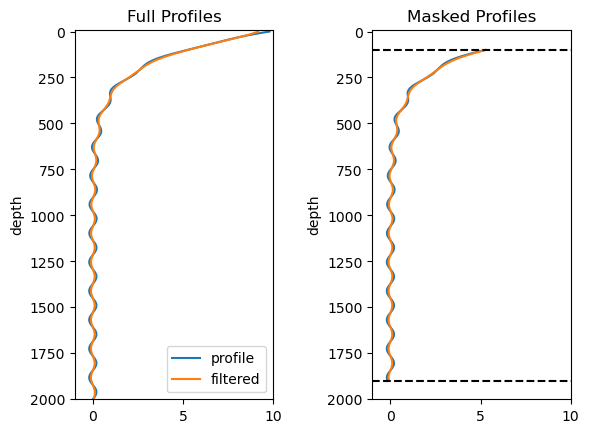

In [18]:
plt.subplot(121)
ds.temperature.isel(profile=0).plot(y='depth',label='profile')
ds_filt_temp.isel(profile=0).plot(y='depth',label='filtered')
plt.ylim(-10,2000)
plt.xlim(-1,10)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Full Profiles')

plt.subplot(122)
ds.temperature.isel(profile=0).where(ds_filt_temp.isel(profile=0).mask==1).plot(y='depth',label='profile')
ds_filt_temp.isel(profile=0).where(ds_filt_temp.isel(profile=0).mask==1).plot(y='depth',label='filtered')
plt.hlines(y=[ds.MLD.isel(profile=0)+lfilter,ds.depth.max()-lfilter],xmin=-1,xmax=10,color='k',linestyle='--')
plt.ylim(-10,2000)
plt.xlim(-1,10)
plt.gca().invert_yaxis()
plt.title('Masked Profiles')

plt.subplots_adjust(wspace=0.5)

### Variance Framework

_Outline steps in calculating EKE (same notation as Steinberg?)_

In [19]:
#square a filtered profile
#this function is from EKE_funcs.py
def get_filt_squared(ds, lfilter, variable,dim1='profile',dim2='depth',bound=True):
    
    ds_filt = get_filt_single(ds, lfilter, variable=variable, dim1=dim1, dim2=dim2, bound=bound)
    ds_filt_squared = ds_filt**2
    
    return ds_filt_squared

In [20]:
#filter a squared profile
#this function is from EKE_funcs.py
def get_squared_filt(ds, lfilter, variable,dim1='profile',dim2='depth',bound=True):
    
    ds_squared = ds[[variable]]**2
    ds_squared_filt = get_filt_single(ds_squared, lfilter, variable=variable, dim1=dim1, dim2=dim2,bound=bound)
    
    return ds_squared_filt

In [21]:
#calculate EKE
#this function is from EKE_funcs.py
def get_EKE(ds, lfilter, variable,dim1='profile',dim2='depth',bound=True):
    
    ds_filt_squared = get_filt_squared(ds, lfilter, dim1=dim1, dim2=dim2, variable=variable,bound=bound)
    ds_squared_filt = get_squared_filt(ds, lfilter, dim1=dim1, dim2=dim2, variable=variable,bound=bound)
    ds_EKE = ds_squared_filt - ds_filt_squared
    
    return ds_EKE

In [22]:
ds_EKE_temp = get_EKE(ds,lfilter,variable='temperature')
ds_EKE_psal = get_EKE(ds,lfilter,variable='salinity')
ds_EKE_spic = get_EKE(ds,lfilter,variable='spice')

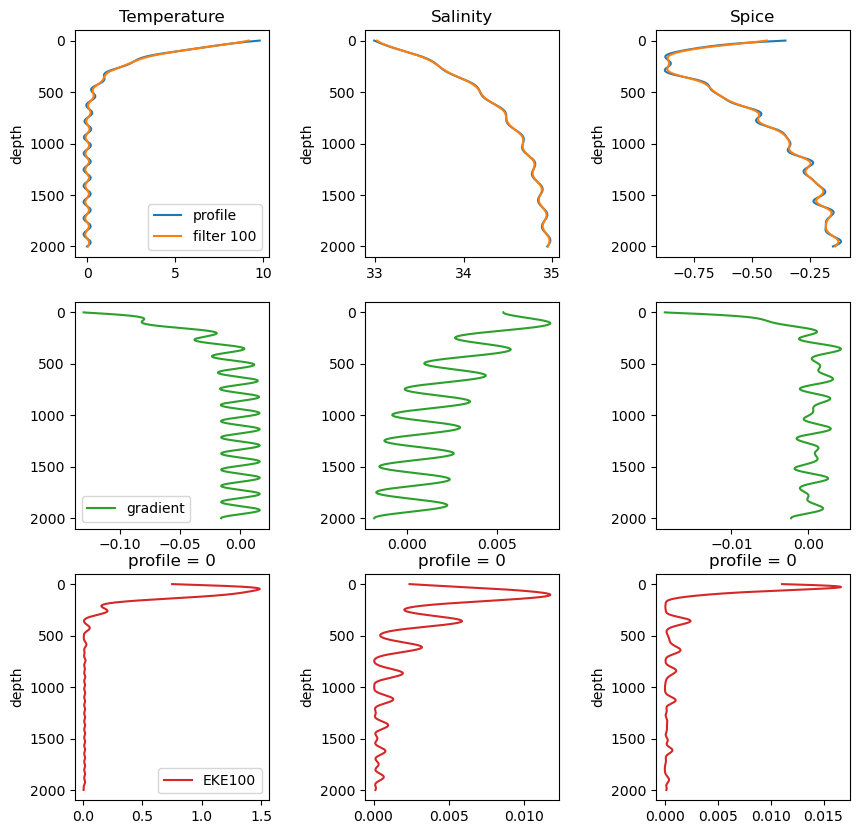

In [23]:
plt.figure(figsize=(10,10))

plt.subplot(331)
ds.temperature.isel(profile=0).plot(y='depth',label='profile')
ds_filt_temp.isel(profile=0).plot(y='depth',label='filter 100')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Temperature')

plt.subplot(332)
ds.salinity.isel(profile=0).plot(y='depth')
ds_filt_psal.isel(profile=0).plot(y='depth')
plt.gca().invert_yaxis()
plt.title('Salinity')

plt.subplot(333)
ds.spice.isel(profile=0).plot(y='depth')
ds_filt_spic.isel(profile=0).plot(y='depth')
plt.gca().invert_yaxis()
plt.title('Spice')

plt.subplot(334)
plt.plot(temp_grad,depth_grid,color='tab:green',label='gradient')
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(335)
plt.plot(psal_grad,depth_grid,color='tab:green')
plt.gca().invert_yaxis()

plt.subplot(336)
plt.plot(spic_grad,depth_grid,color='tab:green')
plt.gca().invert_yaxis()

plt.subplot(337)
ds_EKE_temp.isel(profile=0).plot(y='depth',color='tab:red',label='EKE100')
plt.gca().invert_yaxis()
plt.legend()

plt.subplot(338)
ds_EKE_psal.isel(profile=0).plot(y='depth',color='tab:red')
plt.gca().invert_yaxis()

plt.subplot(339)
ds_EKE_spic.isel(profile=0).plot(y='depth',color='tab:red')
plt.gca().invert_yaxis()

plt.subplots_adjust(wspace=0.5)

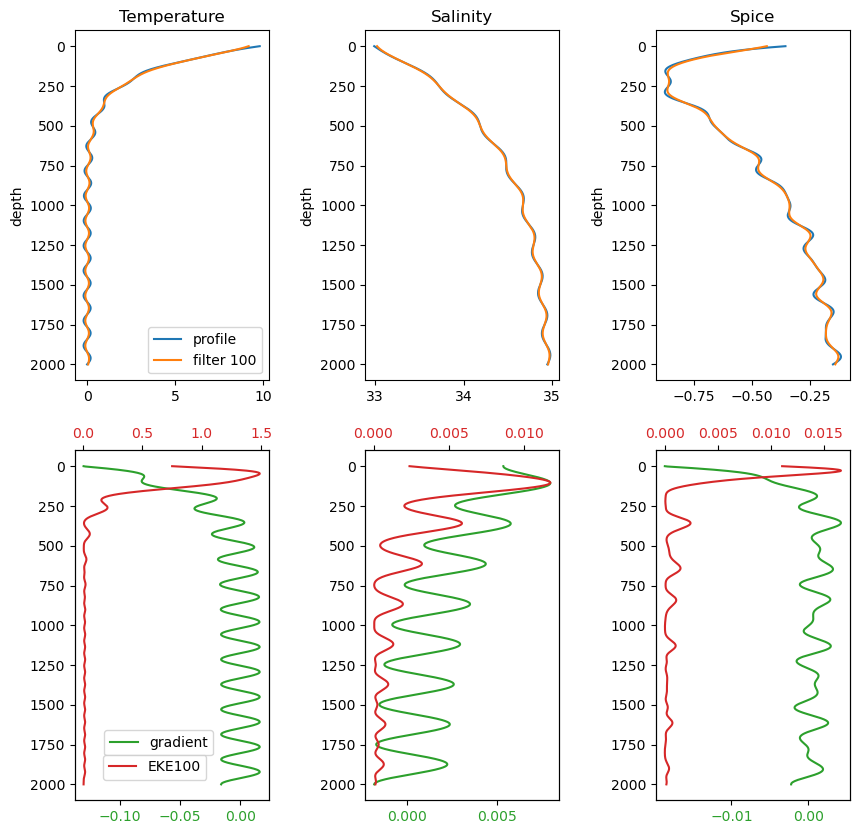

In [24]:
plt.figure(figsize=(10,10))

plt.subplot(231)
ds.temperature.isel(profile=0).plot(y='depth',label='profile')
ds_filt_temp.isel(profile=0).plot(y='depth',label='filter 100')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Temperature')

plt.subplot(232)
ds.salinity.isel(profile=0).plot(y='depth')
ds_filt_psal.isel(profile=0).plot(y='depth')
plt.gca().invert_yaxis()
plt.title('Salinity')

plt.subplot(233)
ds.spice.isel(profile=0).plot(y='depth')
ds_filt_spic.isel(profile=0).plot(y='depth')
plt.gca().invert_yaxis()
plt.title('Spice')

plt.subplot(234)
plt.plot(temp_grad,depth_grid,color='tab:green',label='gradient')
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(0.75,0.22))
plt.xticks(color='tab:green')
plt.twiny()
ds_EKE_temp.isel(profile=0).plot(y='depth',color='tab:red',label='EKE100')
plt.xticks(color='tab:red')
plt.legend(bbox_to_anchor=(0.11,0.15))
plt.title('')

plt.subplot(235)
plt.plot(psal_grad,depth_grid,color='tab:green',label='gradient')
plt.gca().invert_yaxis()
plt.xticks(color='tab:green')
plt.twiny()
ds_EKE_psal.isel(profile=0).plot(y='depth',color='tab:red',label='EKE100')
plt.xticks(color='tab:red')
plt.title('')

plt.subplot(236)
plt.plot(spic_grad,depth_grid,color='tab:green',label='gradient')
plt.gca().invert_yaxis()
plt.xticks(color='tab:green')
plt.twiny()
ds_EKE_spic.isel(profile=0).plot(y='depth',color='tab:red',label='EKE100')
plt.xticks(color='tab:red')
plt.title('')

plt.subplots_adjust(wspace=0.5)

In [25]:
ds_fs_temp = get_filt_squared(ds,lfilter,variable='temperature')
ds_fs_psal = get_filt_squared(ds,lfilter,variable='salinity')
ds_fs_spic = get_filt_squared(ds,lfilter,variable='spice')

ds_sf_temp = get_squared_filt(ds,lfilter,variable='temperature')
ds_sf_psal = get_squared_filt(ds,lfilter,variable='salinity')
ds_sf_spic = get_squared_filt(ds,lfilter,variable='spice')

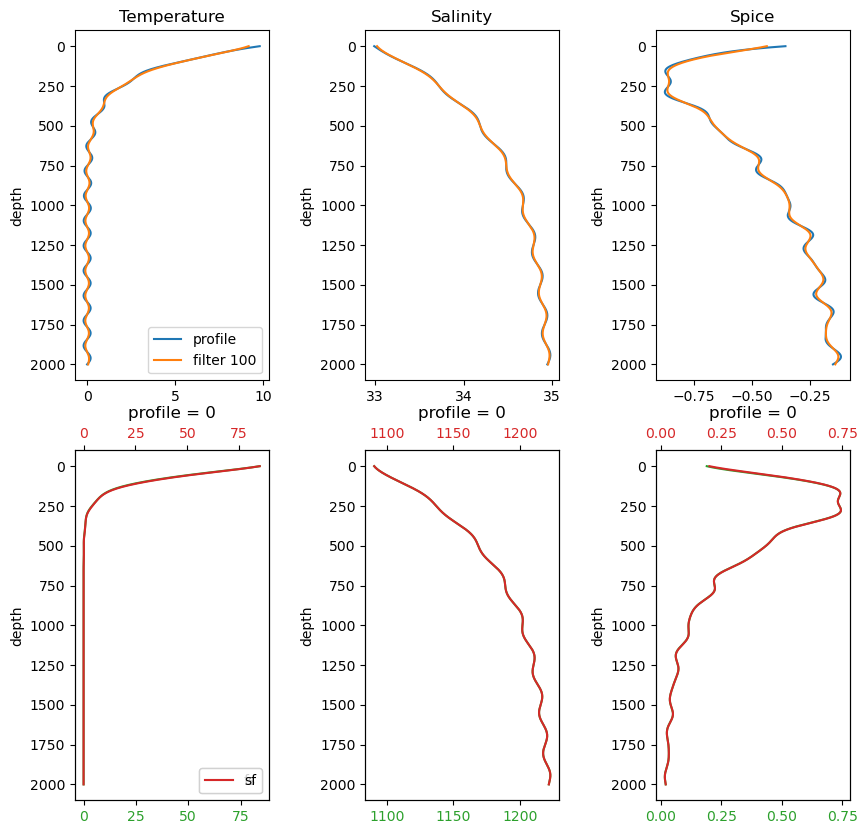

In [26]:
plt.figure(figsize=(10,10))

plt.subplot(231)
ds.temperature.isel(profile=0).plot(y='depth',label='profile')
ds_filt_temp.isel(profile=0).plot(y='depth',label='filter 100')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Temperature')

plt.subplot(232)
ds.salinity.isel(profile=0).plot(y='depth')
ds_filt_psal.isel(profile=0).plot(y='depth')
plt.gca().invert_yaxis()
plt.title('Salinity')

plt.subplot(233)
ds.spice.isel(profile=0).plot(y='depth')
ds_filt_spic.isel(profile=0).plot(y='depth')
plt.gca().invert_yaxis()
plt.title('Spice')

plt.subplot(234)
ds_fs_temp.isel(profile=0).plot(y='depth',color='tab:green',label='fs')
plt.gca().invert_yaxis()
plt.legend()
plt.xticks(color='tab:green')
plt.twiny()
ds_sf_temp.isel(profile=0).plot(y='depth',color='tab:red',label='sf')
plt.xticks(color='tab:red')
plt.legend()
plt.title('')

plt.subplot(235)
ds_fs_psal.isel(profile=0).plot(y='depth',color='tab:green',label='fs')
plt.gca().invert_yaxis()
plt.xticks(color='tab:green')
plt.twiny()
ds_sf_psal.isel(profile=0).plot(y='depth',color='tab:red',label='sf')
plt.xticks(color='tab:red')
plt.title('')

plt.subplot(236)
ds_fs_spic.isel(profile=0).plot(y='depth',color='tab:green',label='fs')
plt.gca().invert_yaxis()
plt.xticks(color='tab:green')
plt.twiny()
ds_sf_spic.isel(profile=0).plot(y='depth',color='tab:red',label='sf')
plt.xticks(color='tab:red')
plt.title('')

plt.subplots_adjust(wspace=0.5)

# Ensamble Approach

Above, the noise added to each profile is described as below:
 
    temp_noise = (1/5)*np.sin((1/25)*(depth_grid))
    psal_noise = (1/25)*np.sin((1/40)*(depth_grid-50))

Here, I think we can keep the same form, just add in a random value of $\phi$ to each profile. Then, density and salinity should be calculated for each profile

In [27]:
low  = -5
high =  5

temps = np.ones([100,1000])
psals = np.ones([100,1000])
denss = np.ones([100,1000])
spics = np.ones([100,1000])

temp_noises = np.ones([100,1000])
psal_noises = np.ones([100,1000])

for n in range(0,100):
    
    temp_random = np.random.uniform(low,high)
    psal_random = np.random.uniform(low,high)
    
    temp_noise = (1/5) *np.sin((1/25)*(depth_grid)+temp_random)
    psal_noise = (1/25)*np.sin((1/40)*(depth_grid)+psal_random)
    
    temp_prof = temp_exp + temp_noise
    psal_prof = psal_exp + psal_noise
    
    dens_prof = gsw.density.rho(psal_prof,temp_prof,depth_grid)
    spic_prof = gsw.spiciness0(psal_prof,temp_prof)
    
    temps[n] = temp_prof
    psals[n] = psal_prof
    denss[n] = dens_prof
    spics[n] = spic_prof
    
    temp_noises[n] = temp_noise
    psal_noises[n] = psal_noise

In [61]:
ds_ensemble = xr.Dataset(coords=dict(profile=(['profile'],range(0,100)),
                           depth=(['depth'],depth_grid)),
           data_vars=dict(temperature=(['profile','depth'],temps),
                          salinity=(['profile','depth'],psals),
                          density=(['profile','depth'],denss),
                          spice=(['profile','depth'],spics),
                          temp_noise=(['profile','depth'],temp_noises),
                          psal_noise=(['profile','depth'],temp_noises)))

In [62]:
ds_ensemble = get_MLD(ds_ensemble,dim1='profile',dim2='depth',variable='density')
ds_ensemble

<xarray.Dataset>
Dimensions:      (profile: 100, depth: 1000)
Coordinates:
  * profile      (profile) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * depth        (depth) float64 0.0 2.002 4.004 ... 1.996e+03 1.998e+03 2e+03
    MLD          (profile) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Data variables:
    temperature  (profile, depth) float64 9.984 9.867 9.752 ... 0.09293 0.07847
    salinity     (profile, depth) float64 32.96 32.97 32.98 ... 34.96 34.96
    density      (profile, depth) float64 1.025e+03 1.025e+03 ... 1.037e+03
    spice        (profile, depth) float64 -0.3445 -0.3593 ... -0.1385 -0.1406
    temp_noise   (profile, depth) float64 -0.01649 -0.0004931 ... 0.07845
    psal_noise   (profile, depth) float64 -0.01649 -0.0004931 ... 0.07845

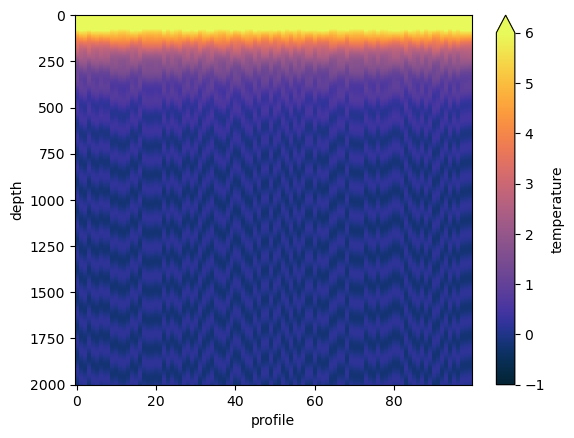

In [63]:
ds_ensemble.temperature.plot(y='depth',cmap=cm.thermal,vmin=-1,vmax=6)
plt.gca().invert_yaxis()

In [36]:
temp_filt         = get_filt_single(ds_ensemble,lfilter,variable='temperature')
temp_filt_squared = temp_filt**2

temp_squared      = ds_ensemble[[variable]]**2
temp_squared_filt = get_filt_single(temp_squared,lfilter,variable='temperature')

temp_EKE          = get_EKE(ds_ensemble,lfilter,variable='temperature')

In [37]:
'''
temp_exp = np.exp(-depth_grid/150)*10
psal_exp = (-np.exp(-depth_grid/550)*2)+35

temp_noise = (1/5) *np.sin((1/25)*(depth_grid)+temp_random)
psal_noise = (1/25)*np.sin((1/40)*(depth_grid)+psal_random)
''';

In [38]:
prof=0

test_filt         = (10)*(np.exp(-depth_grid/150))
test_filt_squared = (10**2)*(np.exp(-depth_grid/150)**2)

test_squared      = (10**2)*(np.exp(-depth_grid/150)**2) + ((1/5)**2)*(np.sin((1/25)*(depth_grid)+ds_ensemble.temp_random.isel(profile=prof))**2) + 2*(10)*(1/5)*(np.exp(-depth_grid/150))*(np.sin((1/25)*(depth_grid)+ds_ensemble.temp_random.isel(profile=0)))
test_squared_filt = (10**2)*(np.exp(-depth_grid/150)**2) + ((1/5)**2)*(np.sin((1/25)*(depth_grid)+ds_ensemble.temp_random.isel(profile=prof))**2)

test_EKE          = test_squared_filt - test_filt_squared

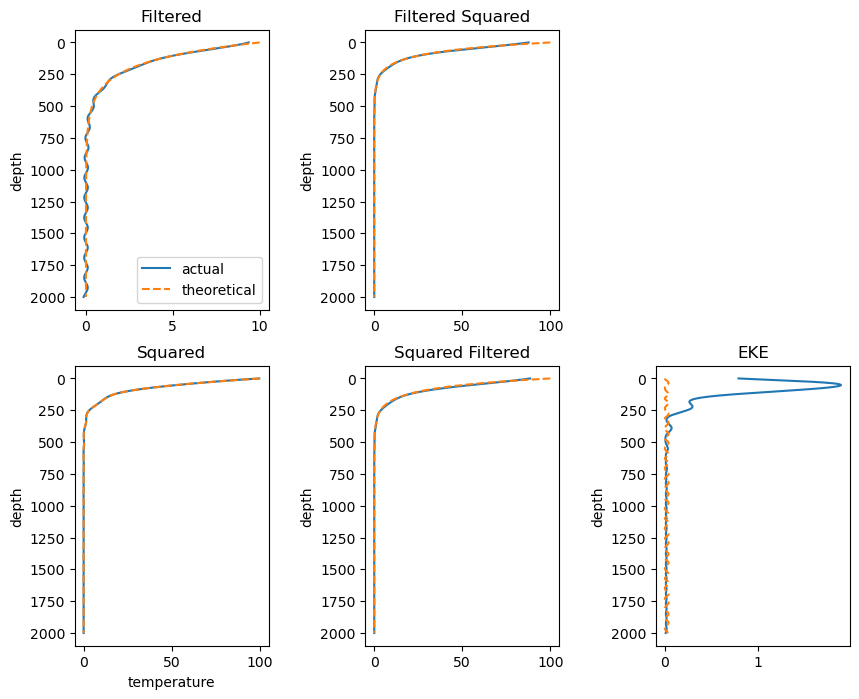

In [39]:
plt.figure(figsize=(10,8))

plt.subplot(231)
temp_filt.isel(profile=prof).plot(y='depth',label='actual')
plt.plot(test_filt,depth_grid,label='theoretical',linestyle='--')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Filtered')

plt.subplot(232)
temp_filt_squared.isel(profile=0).plot(y='depth',label='actual')
plt.plot(test_filt_squared,depth_grid,label='theoretical',linestyle='--')
plt.gca().invert_yaxis()
plt.title('Filtered Squared')

plt.subplot(234)
temp_squared.temperature.isel(profile=prof).plot(y='depth',label='actual')
plt.plot(test_squared,depth_grid,label='theoretical',linestyle='--')
plt.gca().invert_yaxis()
plt.title('Squared')

plt.subplot(235)
temp_squared_filt.isel(profile=prof).plot(y='depth',label='actual')
plt.plot(test_squared_filt,depth_grid,label='theoretical',linestyle='--')
plt.gca().invert_yaxis()
plt.title('Squared Filtered')

plt.subplot(236)
temp_EKE.isel(profile=prof).plot(y='depth',label='actual')
plt.plot(test_EKE,depth_grid,label='theoretical',linestyle='--')
plt.gca().invert_yaxis()
plt.title('EKE')

plt.subplots_adjust(wspace=0.5)

Text(0.5, 1.0, 'EKE')

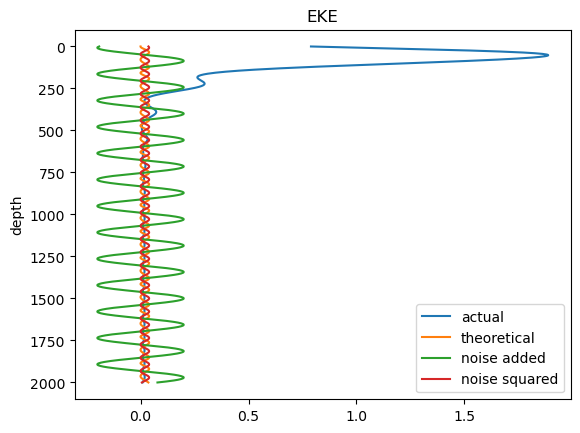

In [40]:
temp_EKE.isel(profile=prof).plot(y='depth',label='actual')
plt.plot(test_EKE,depth_grid,label='theoretical')
plt.plot(temp_noise,depth_grid,label='noise added')
plt.plot(temp_noise**2,depth_grid,label='noise squared')
plt.gca().invert_yaxis()
plt.legend()
plt.title('EKE')

In [41]:
temp_squared_bar      = temp_squared.mean('profile')
temp_squared_bar      = temp_squared_bar.assign_coords(profile=(('profile'),np.array([0])))
temp_squared_bar      = temp_squared_bar.assign_coords(MLD=(('profile'),np.array([0])))
temp_squared_bar_filt = get_filt_single(temp_squared_bar,lfilter,variable='temperature')

**NOTE:**
There was a problem with the above cell, where the function get_filt_single would return an error because if you feed it temp_squared_bar directly (with no processing), it no longer has a profile dimension. The function requires this, so I added a profile dimension and picked the value of 0. It also requires a MLD coordinate (to determine where to set the mask) so I also set this to zero. This will require more careful attention in the future, but this hacky solution works for now.

In [42]:
temp_bar = ds_ensemble.temperature.mean('profile')
temp_bar = xr.Dataset(coords=dict(depth=(['depth'],depth_grid)),
                      data_vars=dict(temperature=(['depth'],temp_bar.data)))
temp_bar = temp_bar.assign_coords(profile=(('profile'),np.array([0])))
temp_bar = temp_bar.assign_coords(MLD=(('profile'),np.array([0])))
temp_bar_filt = get_filt_single(temp_bar,lfilter,variable='temperature')
temp_bar_filt_squared = temp_bar_filt**2

**NOTE:** 
There were similar problems as with the cell above, so I implemented a similar solution. There was an additional error because the initial line for `temp_bar` returns a DataArray instead of a Dataset, so I first created a new Dataset, then added an additional dimension of profile and an additional coordinate of MLD.

In [43]:
temp_variance = (ds_ensemble.temperature**2).mean('profile') - ds_ensemble.temperature.mean('profile')**2

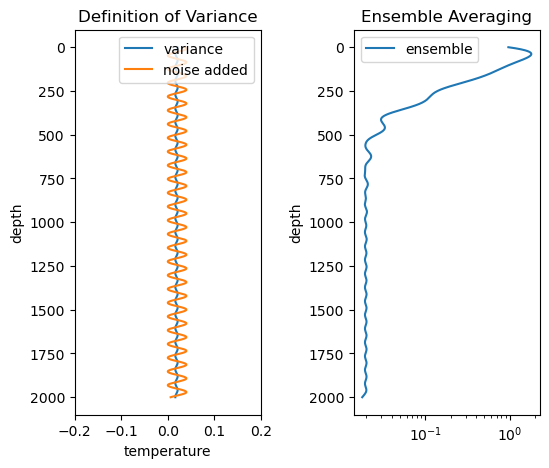

In [44]:
plt.figure(figsize=(6,5))

plt.subplot(121)
temp_variance.plot(y='depth',label='variance')
plt.plot(temp_noise**2,depth_grid,label='noise added')
plt.xlim(-0.2,0.2)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Definition of Variance')

plt.subplot(122)
(temp_squared_bar_filt-temp_bar_filt_squared).plot(y='depth',label='ensemble')
#plt.plot(temp_noise**2,depth_grid,label='noise added')
plt.gca().invert_yaxis()
plt.legend()
plt.xscale('log')
plt.title('Ensemble Averaging')

plt.subplots_adjust(wspace=0.5)

Check without exponential at all: What is EKE of sin wave?

## Metric testing

In [64]:
ds_anom = ds_ensemble.temperature - ds_ensemble.temperature.mean('profile')
ds_var = (ds_anom**2).mean('profile')

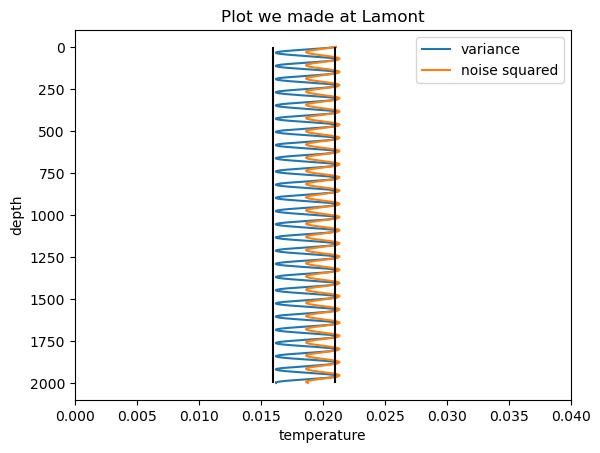

In [90]:
ds_var.plot(y='depth',label='variance')
plt.plot((ds_ensemble.temp_noise**2).mean('profile'),depth_grid, label='noise squared')
plt.gca().invert_yaxis()
plt.xlim(0,0.04)
plt.vlines([0.016,0.021],2000,0,color='k')
plt.title('Plot we made at Lamont')
plt.legend()

Text(0.5, 1.0, 'What I thought the above metric is doing')

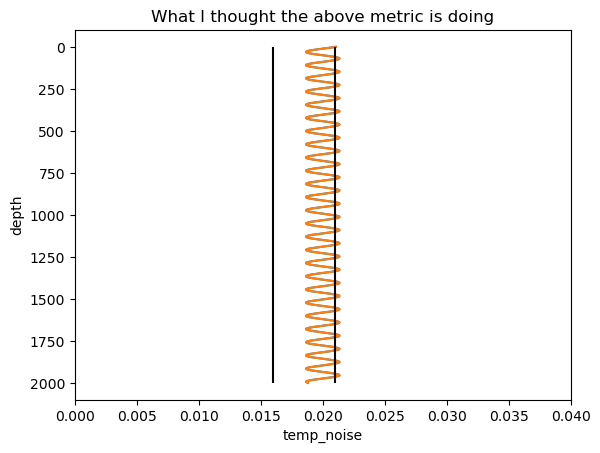

In [89]:
(ds_ensemble.temp_noise**2).mean('profile').plot(y='depth')
plt.plot((ds_ensemble.temp_noise**2).mean('profile'),depth_grid, label='noise squared')
plt.gca().invert_yaxis()
plt.xlim(0,0.04)
plt.vlines([0.016,0.021],2000,0,color='k')
plt.title('What I thought the above metric is doing')

Text(0.5, 1.0, 'What the above metric is actually doing')

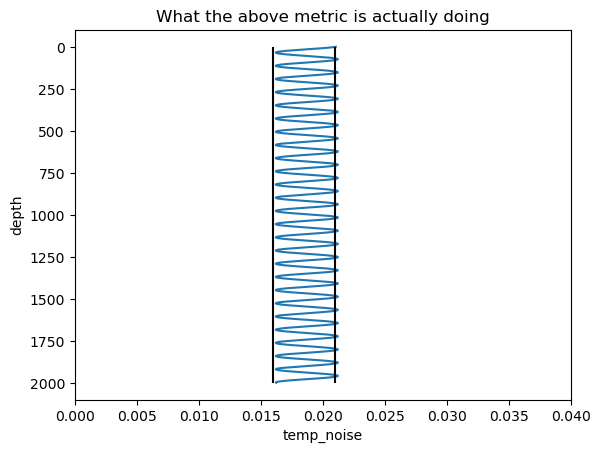

In [86]:
(ds_ensemble.temp_noise**2 + ds_ensemble.temp_noise.mean('profile')**2 - 2*ds_ensemble.temp_noise*ds_ensemble.temp_noise.mean('profile')).mean('profile').plot(y='depth')
plt.gca().invert_yaxis()
plt.xlim(0,0.04)
plt.vlines([0.016,0.021],2000,0,color='k')
plt.title('What the above metric is actually doing')